In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [35]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, walls=20):
        # Set information about the gridworld
        self.height = 10
        self.width = 10
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Set random walls
        for i in range(walls):
            while True:
                x = np.random.randint(0, self.height)
                y = np.random.randint(0, self.width)
                if (x, y) not in [(0, 0), (self.height - 1, self.width - 1)]:
                    break
            self.grid[x, y] = False
            
        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,9))
        
        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]
        
        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -100
        self.grid[ self.gold_location[0], self.gold_location[1]] = 100
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)   

In [36]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.01, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

In [37]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 4)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Here the random agent is ran for 500 trials

Performance is obviously inconsistent and not optimal

In [16]:
environment = GridWorld()
agentQ = Q_Agent(environment)

print("Current position of the agent =", environment.current_location)
print(environment.agent_on_map())
available_actions = environment.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agentQ.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = environment.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", environment.current_location)
print(environment.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


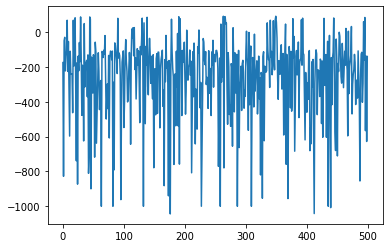

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

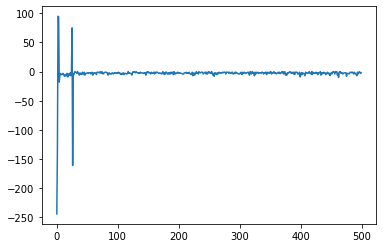

In [39]:
environment = GridWorld()
agent = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agent, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)